In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_raw = pd.read_csv('data/dirty_cafe_sales.csv', sep=';')

In [3]:
item_price_mapping = {
    'Coffee': 2.0,
    'Tea': 1.5,
    'Sandwich': 4.5, #
    'Salad': 5.0,
    'Cake': 3.5, #
    'Cookie': 1.0,
    'Smoothie': 4.0,
    'Juice': 3.0
}

In [4]:
df_raw.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1005331,Coffee,1,2,2,Digital Wallet,Takeaway,04/11/23
1,TXN_1005472,Coffee,4,2,8,Credit Card,NaN,21/04/23
2,TXN_1016246,Coffee,1,2,2,ERROR,NaN,19/01/23
3,TXN_1020478,Coffee,1,2,2,Digital Wallet,Takeaway,09/03/23
4,TXN_1040764,Coffee,3,2,6,Cash,Takeaway,27/07/23


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9822 non-null   object
 4   Total Spent       9850 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


## Data Cleaning ##

In [6]:
df = df_raw.copy()
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       178
Total Spent          150
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

### 1. Item ### 

**1.1 Handling Missing Values**

In [7]:
df[df['Item'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
7397,TXN_1054915,NaN,5,1,5,NaN,In-store,22/01/23
7398,TXN_1124900,NaN,4,4,16,Credit Card,In-store,08/09/23
7399,TXN_1165762,NaN,3,2,6,Credit Card,NaN,22/10/23
7400,TXN_1166001,NaN,UNKNOWN,3,15,Cash,ERROR,NaN
7401,TXN_1205610,NaN,2,1,2,NaN,In-store,19/07/23
...,...,...,...,...,...,...,...,...
7725,TXN_9774251,NaN,2,3,6,Digital Wallet,Takeaway,16/06/23
7726,TXN_9810581,NaN,1,3,3,Cash,NaN,20/11/23
7727,TXN_9817602,NaN,2,4,8,Credit Card,Takeaway,26/12/23
7728,TXN_9945729,NaN,2,5,10,Digital Wallet,NaN,03/02/23


The NaN values in 'Item' still seem to have a corresponding 'Price Per Unit.' This 'Price Per Unit' can be used as a clue to link back to the 'Item Name' using a dictionary called <b>item_price_mapping</b>

In [8]:
# Reverse the structure mapping of item_price_mapping, into {price: item_name}
price_item_mapping = {price: item for item, price in item_price_mapping.items()}
price_item_mapping

{2.0: 'Coffee',
 1.5: 'Tea',
 4.5: 'Sandwich',
 5.0: 'Salad',
 3.5: 'Cake',
 1.0: 'Cookie',
 4.0: 'Smoothie',
 3.0: 'Juice'}

In [9]:
df['Item'].value_counts()

Item
Juice       1171
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Smoothie    1096
Cookie      1092
Tea         1089
UNKNOWN      344
ERROR        292
Name: count, dtype: int64

In [10]:
# Fill the NaN of Item with Mapping price_item_mapping
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(price_item_mapping))

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9822 non-null   object
 4   Total Spent       9850 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


Turns out the total non-null count for Item <b>did not change</b>, meaning the .fillna() method did not affect the values. Looking back at the data type of 'Price Per Unit', which is still an object, this might be the root cause. Let's check the Price Per Unit value counts, but before that, let's replace df with df_raw.

In [12]:
df = df_raw.copy()
df['Price Per Unit'].value_counts()

Price Per Unit
3          1344
4          1249
2          1227
5          1204
1          1143
1.5        1133
3.5        1085
4.5        1083
ERROR       190
UNKNOWN     164
Name: count, dtype: int64

There are two suspicious values (ERROR and UNKNOWN) among those numeric values. This column should be of type float, as it represents a price. Let's handle those values before converting it to float.

In [13]:
df['Price Per Unit'] = df['Price Per Unit'].replace(['ERROR', 'UNKNOWN'], np.nan)
df['Price Per Unit'].value_counts()

Price Per Unit
3      1344
4      1249
2      1227
5      1204
1      1143
1.5    1133
3.5    1085
4.5    1083
Name: count, dtype: int64

In [14]:
df['Price Per Unit'] = df['Price Per Unit'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9667 non-null   object 
 2   Quantity          9862 non-null   object 
 3   Price Per Unit    9468 non-null   float64
 4   Total Spent       9850 non-null   object 
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB


Based on above information, the Price Per Unit are successfully converted into float64. Now let's get back to handling Missing Value on <b>Item</b>

In [15]:
# Fill the NaN of Item with Mapping price_item_mapping
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(price_item_mapping))
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1005331,Coffee,1,2.0,2,Digital Wallet,Takeaway,04/11/23
1,TXN_1005472,Coffee,4,2.0,8,Credit Card,NaN,21/04/23
2,TXN_1016246,Coffee,1,2.0,2,ERROR,NaN,19/01/23
3,TXN_1020478,Coffee,1,2.0,2,Digital Wallet,Takeaway,09/03/23
4,TXN_1040764,Coffee,3,2.0,6,Cash,Takeaway,27/07/23


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9977 non-null   object 
 2   Quantity          9862 non-null   object 
 3   Price Per Unit    9468 non-null   float64
 4   Total Spent       9850 non-null   object 
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB


The total non-null values in the 'Item' column have increased from 9,667 to 9,977. Let's examine the remaining missing values:

In [17]:
df.isnull().sum()

Transaction ID         0
Item                  23
Quantity             138
Price Per Unit       532
Total Spent          150
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [18]:
df[df['Item'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
7402,TXN_1208561,NaN,ERROR,NaN,20,Credit Card,NaN,19/08/23
7448,TXN_2523298,NaN,4,NaN,6,ERROR,In-store,25/03/23
7449,TXN_2536573,NaN,2,NaN,8,Cash,In-store,24/06/23
7473,TXN_3334632,NaN,1,NaN,2,Credit Card,Takeaway,20/11/23
7480,TXN_3495950,NaN,4,NaN,6,Credit Card,In-store,19/02/23
7486,TXN_3611851,NaN,4,NaN,ERROR,Credit Card,NaN,09/02/23
7500,TXN_3803063,NaN,4,NaN,12,Credit Card,Takeaway,23/11/23
7509,TXN_4031509,NaN,4,NaN,16,Credit Card,Takeaway,04/01/23
7514,TXN_4208919,NaN,3,NaN,12,NaN,Takeaway,30/05/23
7543,TXN_4844386,NaN,5,NaN,15,Credit Card,In-store,28/10/23


The remaining missing values in the 'Item' column occurred because of <b>NaN values in 'Price Per Unit,'</b> which makes sense.

We might to have a different approach on finding the Item Name by the <b>Total Spent and Quantity</b> then get the price per unit to finally able to linked back to Item Name. Let's check value for those column Total Spent and Quantity

In [19]:
df['Quantity'].value_counts()

Quantity
5          2013
2          1974
4          1863
3          1849
1          1822
UNKNOWN     171
ERROR       170
Name: count, dtype: int64

In [20]:
df['Total Spent'].value_counts()

Total Spent
6          752
3          719
4          713
10         524
20         507
12         505
9          498
2          497
15         490
8          475
5          468
4.5        446
25         259
16         256
22.5       253
17.5       244
7.5        237
1          232
13.5       232
7          227
3.5        211
14         207
1.5        205
18         200
10.5       198
UNKNOWN    146
ERROR      146
0            3
Name: count, dtype: int64

On those columns each have two suspicious values called (UNKNOWN, ERROR) that need to be replaced with NaN

In [21]:
df['Quantity'] = df['Quantity'].replace(['ERROR', 'UNKNOWN'], np.nan)
df['Quantity'] = df['Quantity'].astype(float)
df['Total Spent'] = df['Total Spent'].replace(['ERROR', 'UNKNOWN'], np.nan)
df['Total Spent'] = df['Total Spent'].astype(float)

In [22]:
df['Quantity'].value_counts()

Quantity
5.0    2013
2.0    1974
4.0    1863
3.0    1849
1.0    1822
Name: count, dtype: int64

In [23]:
df['Total Spent'].value_counts()

Total Spent
6.0     752
3.0     719
4.0     713
10.0    524
20.0    507
12.0    505
9.0     498
2.0     497
15.0    490
8.0     475
5.0     468
4.5     446
25.0    259
16.0    256
22.5    253
17.5    244
7.5     237
13.5    232
1.0     232
7.0     227
3.5     211
14.0    207
1.5     205
18.0    200
10.5    198
0.0       3
Name: count, dtype: int64

After ensuring there are no more invalid values in the 'Total Spent' and 'Quantity' columns and successfully converting them to float, the 'Price Per Unit' values can now be replaced using Total Spent / Quantity.

In [24]:
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Total Spent']/df['Quantity'])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9977 non-null   object 
 2   Quantity          9521 non-null   float64
 3   Price Per Unit    9965 non-null   float64
 4   Total Spent       9558 non-null   float64
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


The total non-null values in 'Price Per Unit' have increased compared to last time, which is a good signal to conduct re-mapping for 'Item'.

In [26]:
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(price_item_mapping))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9998 non-null   object 
 2   Quantity          9521 non-null   float64
 3   Price Per Unit    9965 non-null   float64
 4   Total Spent       9558 non-null   float64
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


In [28]:
df[df['Item'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
7402,TXN_1208561,NaN,NaN,NaN,20.0,Credit Card,NaN,19/08/23
7486,TXN_3611851,NaN,4.0,NaN,NaN,Credit Card,NaN,09/02/23


The data still has some missing 'Item' values. Since there are no more clues, it is better to categorize them as 'Others'.

In [29]:
df['Item'] = df['Item'].fillna('Others')

**1.2 Handling Inappropriate Values**

In [30]:
df['Item'].value_counts()

Item
Juice       1256
Coffee      1208
Salad       1186
Smoothie    1185
Cake        1139
Cookie      1132
Sandwich    1131
Tea         1125
UNKNOWN      344
ERROR        292
Others         2
Name: count, dtype: int64

Apparently there are two suspicious Item Name which are UNKNOWN and ERROR. Let's try to handle it by utilizing price_item_mapping dictioanry

In [31]:
df[np.logical_or(df['Item'] == 'UNKNOWN', df['Item'] == 'ERROR')]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
2257,TXN_1082717,ERROR,NaN,NaN,9.0,Digital Wallet,In-store,13/12/23
2258,TXN_1118799,ERROR,4.0,4.0,NaN,Credit Card,Takeaway,19/09/23
2259,TXN_1124796,ERROR,5.0,1.5,7.5,Credit Card,NaN,28/10/23
2260,TXN_1135761,ERROR,3.0,3.0,9.0,Digital Wallet,NaN,30/01/23
2261,TXN_1185003,ERROR,5.0,3.0,15.0,Cash,Takeaway,06/01/23
...,...,...,...,...,...,...,...,...
7392,TXN_9894204,UNKNOWN,2.0,2.0,4.0,Cash,Takeaway,08/08/23
7393,TXN_9904042,UNKNOWN,4.0,4.0,16.0,Credit Card,NaN,09/06/23
7394,TXN_9914084,UNKNOWN,1.0,2.0,2.0,ERROR,Takeaway,16/06/23
7395,TXN_9950775,UNKNOWN,4.0,5.0,20.0,Credit Card,Takeaway,20/02/23


In [32]:
df['Item'] = df.apply(lambda row: price_item_mapping.get(row['Price Per Unit'], row['Item'])
                      if row['Item'] in ['UNKNOWN', 'ERROR'] else row['Item'], axis=1)
df['Item'].value_counts()

Item
Juice       1418
Smoothie    1323
Coffee      1291
Salad       1272
Cookie      1213
Tea         1207
Cake        1139
Sandwich    1131
ERROR          2
UNKNOWN        2
Others         2
Name: count, dtype: int64

Apparently, the dataframe still has four rows with ['ERROR', 'UNKNOWN'] values in 'Item'. Let’s categorize them as 'Others' as well.

In [33]:
df['Item'] = df['Item'].replace(['ERROR', 'UNKNOWN'],'Others')
df['Item'].value_counts()

Item
Juice       1418
Smoothie    1323
Coffee      1291
Salad       1272
Cookie      1213
Tea         1207
Cake        1139
Sandwich    1131
Others         6
Name: count, dtype: int64

### 2. Transaction Date ### 

**2.1 Handling Missing Values**

In [34]:
df[df['Transaction Date'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
26,TXN_1193930,Coffee,1.0,2.0,2.0,Cash,NaN,NaN
68,TXN_1529904,Coffee,1.0,2.0,2.0,Credit Card,In-store,NaN
73,TXN_1568657,Coffee,2.0,2.0,4.0,Cash,NaN,NaN
223,TXN_2574545,Coffee,NaN,2.0,4.0,NaN,In-store,NaN
226,TXN_2607233,Coffee,3.0,2.0,6.0,Cash,Takeaway,NaN
...,...,...,...,...,...,...,...,...
9717,TXN_4030010,Sandwich,5.0,4.5,22.5,NaN,Takeaway,NaN
9725,TXN_2376525,Sandwich,5.0,4.5,22.5,ERROR,NaN,NaN
9793,TXN_4620459,Sandwich,5.0,4.5,22.5,Cash,ERROR,NaN
9826,TXN_7133645,Sandwich,5.0,4.5,22.5,Credit Card,Takeaway,NaN


The dataframe has 159 rows missing 'Transaction Date', since this column is mandatory and try to fill up the missing date with the previous available row.

In [35]:
df['Transaction Date'] = df['Transaction Date'].ffill() # Klo bfill jadinya 12/10/23
df[df['Transaction Date'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date


In [36]:
df.loc[[25,26,27],:]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
25,TXN_1192970,Coffee,2.0,2.0,4.0,Digital Wallet,Takeaway,17/06/23
26,TXN_1193930,Coffee,1.0,2.0,2.0,Cash,NaN,17/06/23
27,TXN_1203191,Coffee,5.0,2.0,10.0,ERROR,In-store,12/10/23


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              10000 non-null  object 
 2   Quantity          9521 non-null   float64
 3   Price Per Unit    9965 non-null   float64
 4   Total Spent       9558 non-null   float64
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  10000 non-null  object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


**2.2 Handling Invalid Values**

Before converting data type of 'Transaction Date' into date, better to handle the invalid value and fill up the missing date with the previous available row.

In [38]:
df[np.logical_or(df['Transaction Date']=='ERROR', df['Transaction Date']=='UNKNOWN')]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
84,TXN_1621227,Coffee,2.0,2.0,4.0,Cash,NaN,UNKNOWN
106,TXN_1789644,Coffee,4.0,2.0,8.0,Credit Card,In-store,ERROR
112,TXN_1827937,Coffee,1.0,2.0,2.0,NaN,Takeaway,UNKNOWN
143,TXN_2062604,Coffee,2.0,2.0,4.0,Cash,In-store,ERROR
195,TXN_2354774,Coffee,5.0,2.0,10.0,NaN,In-store,UNKNOWN
...,...,...,...,...,...,...,...,...
9860,TXN_1929109,Sandwich,5.0,4.5,22.5,NaN,NaN,ERROR
9876,TXN_9877722,Sandwich,5.0,4.5,22.5,Digital Wallet,In-store,UNKNOWN
9878,TXN_1526920,Sandwich,5.0,4.5,22.5,Digital Wallet,Takeaway,ERROR
9916,TXN_4653861,Sandwich,NaN,4.5,18.0,Cash,Takeaway,ERROR


In [39]:
df['Transaction Date'] = df['Transaction Date'].replace(['ERROR','UNKNOWN'],np.nan).ffill()
df[df['Transaction Date'].isnull()]


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date


In [40]:
df.loc[[105,106,107,142, 143, 144],:]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
105,TXN_1785371,Coffee,1.0,2.0,2.0,UNKNOWN,Takeaway,16/01/23
106,TXN_1789644,Coffee,4.0,2.0,8.0,Credit Card,In-store,16/01/23
107,TXN_1795044,Coffee,2.0,2.0,4.0,Digital Wallet,UNKNOWN,15/08/23
142,TXN_2056358,Coffee,3.0,2.0,6.0,Cash,In-store,17/09/23
143,TXN_2062604,Coffee,2.0,2.0,4.0,Cash,In-store,17/09/23
144,TXN_2064360,Coffee,4.0,2.0,8.0,Digital Wallet,In-store,30/08/23


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              10000 non-null  object 
 2   Quantity          9521 non-null   float64
 3   Price Per Unit    9965 non-null   float64
 4   Total Spent       9558 non-null   float64
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  10000 non-null  object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


In [42]:
# Convert data type into datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              10000 non-null  object        
 2   Quantity          9521 non-null   float64       
 3   Price Per Unit    9965 non-null   float64       
 4   Total Spent       9558 non-null   float64       
 5   Payment Method    7421 non-null   object        
 6   Location          6735 non-null   object        
 7   Transaction Date  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 625.1+ KB


/var/folders/lg/fsm8s9v909b1k6v2b54vczfw0000gn/T/ipykernel_3867/3474508730.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])


The 'Transaction Date' is successfully converted into datetime

### 3. Price Per Unit ### 

**3.1 Handling Missing Values**

In [43]:
df[df['Price Per Unit'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
270,TXN_3071092,Coffee,NaN,NaN,4.0,ERROR,NaN,2023-08-09
774,TXN_6905143,Coffee,5.0,NaN,NaN,Cash,ERROR,2023-09-08
1507,TXN_3705445,Cookie,5.0,NaN,NaN,Cash,In-store,2023-09-13
1685,TXN_5118799,Cookie,2.0,NaN,NaN,Cash,Takeaway,2023-04-23
1705,TXN_5308047,Cookie,NaN,NaN,1.0,Credit Card,NaN,2023-10-28
1804,TXN_6177081,Cookie,NaN,NaN,1.0,Cash,ERROR,2023-07-26
1828,TXN_6424202,Cookie,2.0,NaN,NaN,Credit Card,In-store,2023-11-20
1880,TXN_6859249,Cookie,NaN,NaN,2.0,NaN,UNKNOWN,2023-08-01
2257,TXN_1082717,Others,NaN,NaN,9.0,Digital Wallet,In-store,2023-12-13
2537,TXN_9646000,Others,2.0,NaN,NaN,NaN,In-store,2023-12-14


There are 32 rows with a missing 'Price Per Unit'. This missing value can be handled through linking Item with <b>item_price_mapping</b>

In [44]:
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Item'].map(item_price_mapping))
len(df[df['Price Per Unit'].isnull()])

6

In [45]:
df[df['Price Per Unit'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
2257,TXN_1082717,Others,NaN,NaN,9.0,Digital Wallet,In-store,2023-12-13
2537,TXN_9646000,Others,2.0,NaN,NaN,NaN,In-store,2023-12-14
7296,TXN_7376255,Others,NaN,NaN,25.0,NaN,In-store,2023-05-27
7303,TXN_7524977,Others,4.0,NaN,NaN,ERROR,NaN,2023-09-12
7402,TXN_1208561,Others,NaN,NaN,20.0,Credit Card,NaN,2023-08-19
7486,TXN_3611851,Others,4.0,NaN,NaN,Credit Card,NaN,2023-09-02


The remaining missing Price Per Unit still there due to 'Others' on Item Name

In [46]:
df['Price Per Unit'].value_counts()

Price Per Unit
3.0    1418
4.0    1323
2.0    1291
5.0    1272
1.0    1213
1.5    1207
3.5    1139
4.5    1129
0.0       2
Name: count, dtype: int64

There are no more invalid values on Price Per Unit. 

### 4. Quantity ### 

**4.1 Handling Missing Values**

In [47]:
df[df['Quantity'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
80,TXN_1602123,Coffee,NaN,2.0,2.0,Cash,NaN,2023-11-04
85,TXN_1629218,Coffee,NaN,2.0,6.0,Digital Wallet,NaN,2023-06-27
134,TXN_1975184,Coffee,NaN,2.0,NaN,Digital Wallet,NaN,2023-01-15
185,TXN_2291079,Coffee,NaN,2.0,2.0,Cash,NaN,2023-07-10
188,TXN_2305908,Coffee,NaN,2.0,8.0,Cash,NaN,2023-04-25
...,...,...,...,...,...,...,...,...
9947,TXN_8086161,Sandwich,NaN,4.5,9.0,Cash,In-store,2023-10-03
9948,TXN_4152460,Sandwich,NaN,4.5,13.5,Cash,Takeaway,2023-01-05
9949,TXN_2023651,Sandwich,NaN,4.5,NaN,Cash,In-store,2023-05-25
9950,TXN_1547245,Sandwich,NaN,4.5,NaN,NaN,Takeaway,2023-11-09


Missing Quantity can be derived by Total Spent divided by Price Per unit: 

In [48]:
df['Quantity'] = df['Quantity'].fillna(df['Total Spent']/df['Price Per Unit'])
len(df[df['Quantity'].isnull()])

23

In [49]:
df[df['Quantity'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
134,TXN_1975184,Coffee,NaN,2.0,NaN,Digital Wallet,NaN,2023-01-15
478,TXN_4628338,Coffee,NaN,2.0,NaN,Cash,NaN,2023-12-25
677,TXN_6297232,Coffee,NaN,2.0,NaN,NaN,NaN,2023-07-04
704,TXN_6470865,Coffee,NaN,2.0,NaN,Digital Wallet,Takeaway,2023-09-18
1121,TXN_9669616,Coffee,NaN,2.0,NaN,NaN,ERROR,2023-03-06
1611,TXN_4550558,Cookie,NaN,1.0,NaN,Credit Card,In-store,2023-04-08
1768,TXN_5884081,Cookie,NaN,1.0,NaN,Digital Wallet,In-store,2023-05-07
2257,TXN_1082717,Others,NaN,NaN,9.0,Digital Wallet,In-store,2023-12-13
2752,TXN_2546684,Juice,NaN,3.0,NaN,Digital Wallet,Takeaway,2023-08-04
2805,TXN_2962976,Juice,NaN,3.0,NaN,NaN,NaN,2023-03-17


In [50]:
df['Quantity'].value_counts()

Quantity
5.0    2108
2.0    2056
3.0    1946
4.0    1940
1.0    1926
0.0       1
Name: count, dtype: int64

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              10000 non-null  object        
 2   Quantity          9977 non-null   float64       
 3   Price Per Unit    9994 non-null   float64       
 4   Total Spent       9558 non-null   float64       
 5   Payment Method    7421 non-null   object        
 6   Location          6735 non-null   object        
 7   Transaction Date  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 625.1+ KB


Remaining missing Quantity occured because of either Total Spent is null or Others on Item. 

### 5. Total Spent ### 

**5.1 Handling Missing Values**

In [52]:
df[df['Total Spent'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
23,TXN_1191659,Coffee,4.0,2.0,NaN,Credit Card,In-store,2023-11-21
33,TXN_1254663,Coffee,3.0,2.0,NaN,NaN,NaN,2023-08-15
45,TXN_1367723,Coffee,3.0,2.0,NaN,Cash,In-store,2023-10-25
71,TXN_1546695,Coffee,5.0,2.0,NaN,NaN,Takeaway,2023-06-03
91,TXN_1689024,Coffee,5.0,2.0,NaN,Credit Card,In-store,2023-04-17
...,...,...,...,...,...,...,...,...
9932,TXN_9924732,Sandwich,NaN,4.5,NaN,Credit Card,In-store,2023-01-18
9949,TXN_2023651,Sandwich,NaN,4.5,NaN,Cash,In-store,2023-05-25
9950,TXN_1547245,Sandwich,NaN,4.5,NaN,NaN,Takeaway,2023-11-09
9971,TXN_1525583,Sandwich,3.0,4.5,NaN,Cash,Takeaway,2023-05-20


Missing Total Spent can be derived from Price Per Unit mutliply with Quantity

In [53]:
df['Total Spent'] = df['Total Spent'].fillna(df['Price Per Unit']*df['Quantity'])
len(df[df['Total Spent'].isnull()])

23

In [54]:
df[df['Total Spent'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
134,TXN_1975184,Coffee,NaN,2.0,NaN,Digital Wallet,NaN,2023-01-15
478,TXN_4628338,Coffee,NaN,2.0,NaN,Cash,NaN,2023-12-25
677,TXN_6297232,Coffee,NaN,2.0,NaN,NaN,NaN,2023-07-04
704,TXN_6470865,Coffee,NaN,2.0,NaN,Digital Wallet,Takeaway,2023-09-18
1121,TXN_9669616,Coffee,NaN,2.0,NaN,NaN,ERROR,2023-03-06
1611,TXN_4550558,Cookie,NaN,1.0,NaN,Credit Card,In-store,2023-04-08
1768,TXN_5884081,Cookie,NaN,1.0,NaN,Digital Wallet,In-store,2023-05-07
2537,TXN_9646000,Others,2.0,NaN,NaN,NaN,In-store,2023-12-14
2752,TXN_2546684,Juice,NaN,3.0,NaN,Digital Wallet,Takeaway,2023-08-04
2805,TXN_2962976,Juice,NaN,3.0,NaN,NaN,NaN,2023-03-17


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              10000 non-null  object        
 2   Quantity          9977 non-null   float64       
 3   Price Per Unit    9994 non-null   float64       
 4   Total Spent       9977 non-null   float64       
 5   Payment Method    7421 non-null   object        
 6   Location          6735 non-null   object        
 7   Transaction Date  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 625.1+ KB


### 6. Payment Method ### 

**6.1 Handling Missing Values**

In [56]:
df[df['Payment Method'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
6,TXN_1074435,Coffee,1.0,2.0,2.0,NaN,In-store,2023-11-25
7,TXN_1077060,Coffee,3.0,2.0,6.0,NaN,Takeaway,2023-08-22
15,TXN_1145888,Coffee,4.0,2.0,8.0,NaN,NaN,2023-01-26
16,TXN_1148945,Coffee,1.0,2.0,2.0,NaN,UNKNOWN,2023-05-09
19,TXN_1158197,Coffee,2.0,2.0,4.0,NaN,Takeaway,2023-05-21
...,...,...,...,...,...,...,...,...
9974,TXN_3092390,Sandwich,3.0,4.5,13.5,NaN,In-store,2023-07-24
9978,TXN_4897993,Sandwich,4.0,4.5,18.0,NaN,In-store,2023-07-12
9987,TXN_7122708,Sandwich,5.0,4.5,22.5,NaN,Takeaway,2023-06-23
9988,TXN_2004781,Sandwich,5.0,4.5,22.5,NaN,Takeaway,2023-04-20


There are a lot of records with missing values on Payment Method, drop the rows won't be a good option then categorized them as 'Others'.

In [57]:
df['Payment Method'] = df['Payment Method'].fillna('Others')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              10000 non-null  object        
 2   Quantity          9977 non-null   float64       
 3   Price Per Unit    9994 non-null   float64       
 4   Total Spent       9977 non-null   float64       
 5   Payment Method    10000 non-null  object        
 6   Location          6735 non-null   object        
 7   Transaction Date  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 625.1+ KB


**6.2 Handling Invalid Values**

In [58]:
df['Payment Method'].value_counts()

Payment Method
Others            2579
Digital Wallet    2291
Credit Card       2273
Cash              2258
ERROR              306
UNKNOWN            293
Name: count, dtype: int64

There are quite a lot of ERROR and UNKNOWN on Payment Method. Those two values will be categorized ad 'Others'

In [59]:
df['Payment Method'] = df['Payment Method'].replace(['ERROR', 'UNKNOWN'],'Others')
df['Payment Method'].value_counts()

Payment Method
Others            3178
Digital Wallet    2291
Credit Card       2273
Cash              2258
Name: count, dtype: int64

### 7. Location ### 

**7.1 Handling Missing Values**

In [60]:
df[df['Location'].isnull()]

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
1,TXN_1005472,Coffee,4.0,2.0,8.0,Credit Card,NaN,2023-04-21
2,TXN_1016246,Coffee,1.0,2.0,2.0,Others,NaN,2023-01-19
12,TXN_1120969,Coffee,2.0,2.0,4.0,Credit Card,NaN,2023-04-15
14,TXN_1141920,Coffee,4.0,2.0,8.0,Digital Wallet,NaN,2023-10-26
15,TXN_1145888,Coffee,4.0,2.0,8.0,Others,NaN,2023-01-26
...,...,...,...,...,...,...,...,...
9972,TXN_5542500,Sandwich,3.0,4.5,13.5,Credit Card,NaN,2023-07-19
9979,TXN_3844347,Sandwich,4.0,4.5,18.0,Cash,NaN,2023-04-10
9980,TXN_9180345,Sandwich,4.0,4.5,18.0,Digital Wallet,NaN,2023-06-13
9981,TXN_5663260,Sandwich,4.0,4.5,18.0,Digital Wallet,NaN,2023-08-10


There are around 3K records with a missing 'Location'. This could have occurred due to various reasons, such as the UI/UX not making it a mandatory input or the system itself not being stable yet.

In [61]:
df['Location'] = df['Location'].fillna('Others')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              10000 non-null  object        
 2   Quantity          9977 non-null   float64       
 3   Price Per Unit    9994 non-null   float64       
 4   Total Spent       9977 non-null   float64       
 5   Payment Method    10000 non-null  object        
 6   Location          10000 non-null  object        
 7   Transaction Date  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 625.1+ KB


**7.2 Handling Invalid Values**

In [62]:
df['Location'].value_counts()

Location
Others      3265
Takeaway    3022
In-store    3017
ERROR        358
UNKNOWN      338
Name: count, dtype: int64

In [63]:
df['Location'] = df['Location'].replace(['ERROR', 'UNKNOWN'],'Others')
df['Location'].value_counts()

Location
Others      3961
Takeaway    3022
In-store    3017
Name: count, dtype: int64

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              10000 non-null  object        
 2   Quantity          9977 non-null   float64       
 3   Price Per Unit    9994 non-null   float64       
 4   Total Spent       9977 non-null   float64       
 5   Payment Method    10000 non-null  object        
 6   Location          10000 non-null  object        
 7   Transaction Date  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 625.1+ KB


### 8. New Column ### 

**8.1 Adding Specific Date Component**

In [65]:
df['Day of the Week'] = df['Transaction Date'].dt.day_name()
df['Transaction Month'] = df['Transaction Date'].dt.month_name()
df['Month ID'] = df['Transaction Date'].dt.month
df['Day ID'] = df['Transaction Date'].dt.dayofweek
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Day of the Week,Transaction Month,Month ID,Day ID
0,TXN_1005331,Coffee,1.0,2.0,2.0,Digital Wallet,Takeaway,2023-04-11,Tuesday,April,4,1
1,TXN_1005472,Coffee,4.0,2.0,8.0,Credit Card,Others,2023-04-21,Friday,April,4,4
2,TXN_1016246,Coffee,1.0,2.0,2.0,Others,Others,2023-01-19,Thursday,January,1,3
3,TXN_1020478,Coffee,1.0,2.0,2.0,Digital Wallet,Takeaway,2023-09-03,Sunday,September,9,6
4,TXN_1040764,Coffee,3.0,2.0,6.0,Cash,Takeaway,2023-07-27,Thursday,July,7,3


### 9. Outlier ### 

**9.1 On Total Spent**

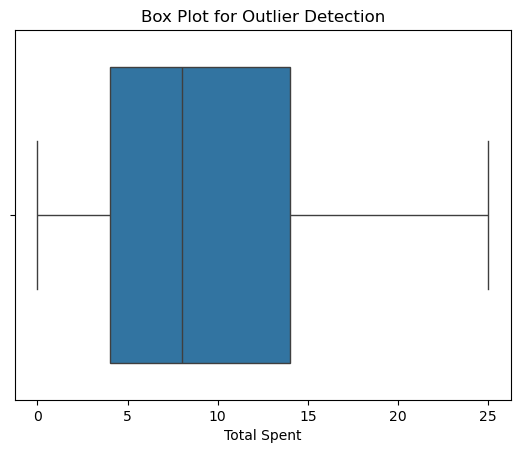

In [138]:
# Box Plot
sns.boxplot(x=df['Total Spent'])
plt.title("Box Plot for Outlier Detection")
plt.show()

In [140]:
Q1 = df['Total Spent'].quantile(0.25)
Q3 = df['Total Spent'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Total Spent'] < lower_bound) | (df['Total Spent'] > upper_bound)]
print(outliers)


Empty DataFrame
Columns: [Transaction ID, Item, Quantity, Price Per Unit, Total Spent, Payment Method, Location, Transaction Date, Day of the Week, Transaction Month, Month ID, Day ID, Date]
Index: []


No outlier are detected on Total Spent, which is a good sign to proceed on to the visualization

**9.2 Overall Distribution**

/var/folders/lg/fsm8s9v909b1k6v2b54vczfw0000gn/T/ipykernel_3867/2221230347.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Item'].value_counts().index,y=df['Item'].value_counts().values, edgecolor='green', palette='Greens')
/var/folders/lg/fsm8s9v909b1k6v2b54vczfw0000gn/T/ipykernel_3867/2221230347.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Quantity',data=df,edgecolor='blue', palette='Blues')
/var/folders/lg/fsm8s9v909b1k6v2b54vczfw0000gn/T/ipykernel_3867/2221230347.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(

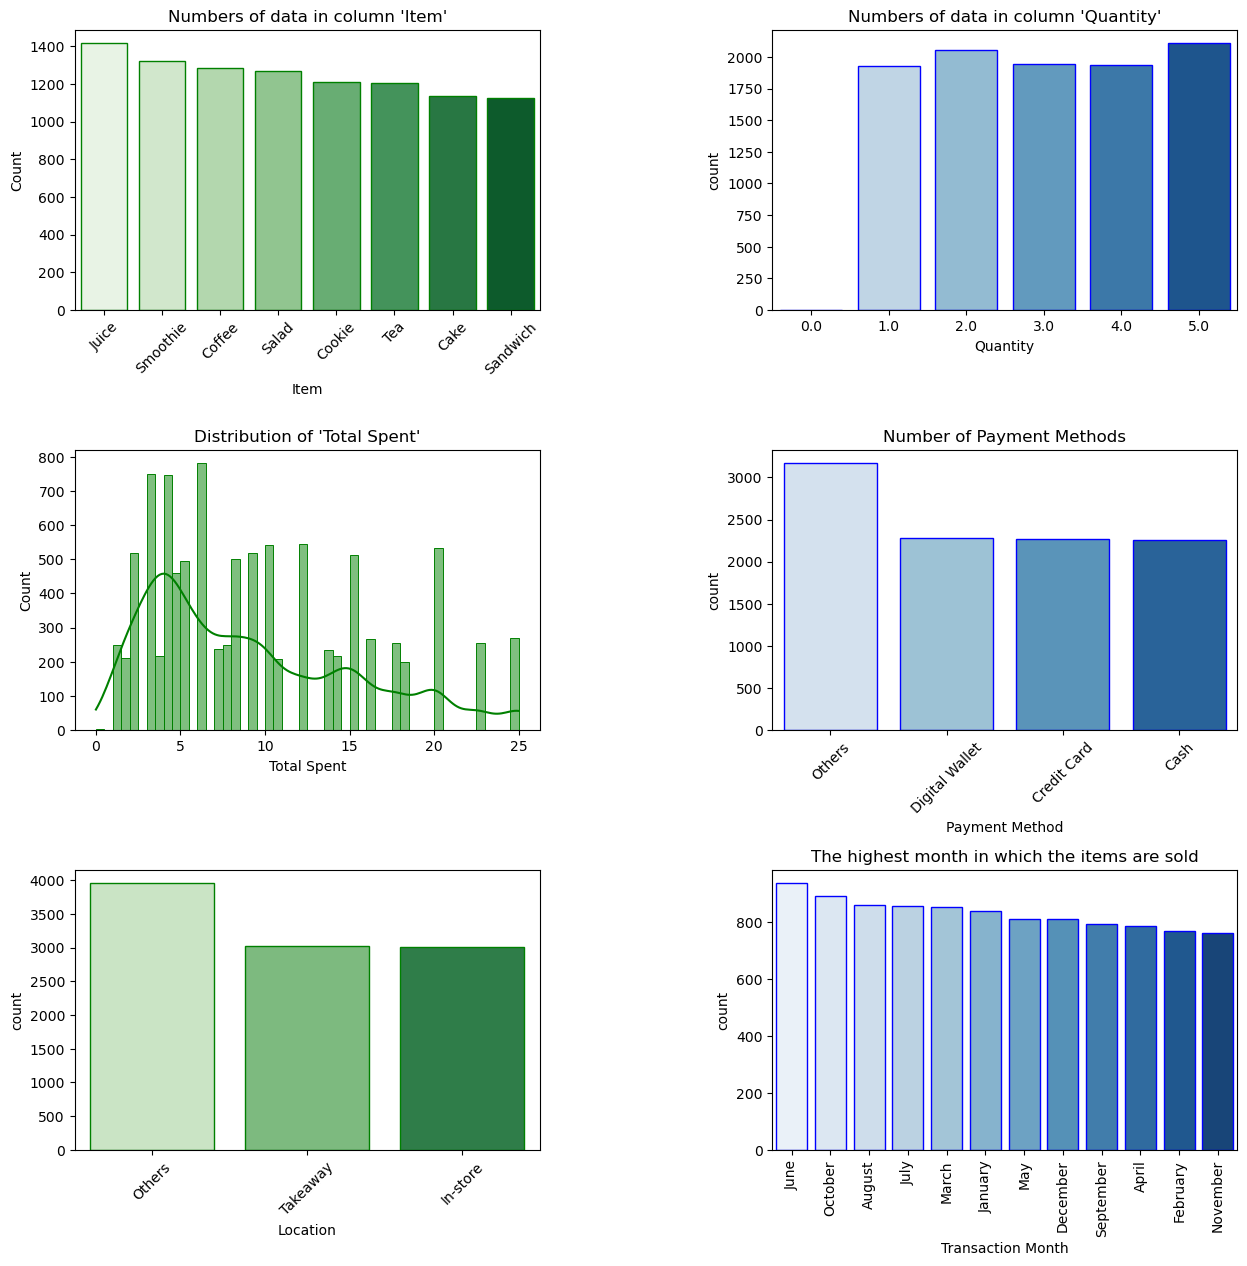

In [161]:
plt.figure(figsize=(15,20))
plt.subplot(4,2,1)
sns.barplot(x=df['Item'].value_counts().index,y=df['Item'].value_counts().values, edgecolor='green', palette='Greens')
plt.title("Numbers of data in column 'Item'")
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.subplot(4,2,2)
sns.countplot(x='Quantity',data=df,edgecolor='blue', palette='Blues')
plt.title("Numbers of data in column 'Quantity'")

plt.xticks()
#
plt.subplot(4,2,3)
sns.histplot(df['Total Spent'],bins=50,kde=True,color='green',edgecolor='green')
plt.title("Distribution of 'Total Spent'")
plt.xticks()
#


#
plt.subplot(4,2,4)
sns.barplot(x=df['Payment Method'].value_counts().index,y=df['Payment Method'].value_counts().values,edgecolor='blue',palette='Blues')
plt.xticks(rotation=45)
plt.title('Number of Payment Methods')
plt.ylabel('count')

#

plt.subplot(4,2,5)
sns.barplot(x=df['Location'].value_counts().index,y=df['Location'].value_counts().values,edgecolor='green',palette='Greens')
plt.xticks(rotation=45)
plt.ylabel('count')


#
plt.subplot(4,2,6)
sns.barplot(x=df['Transaction Month'].value_counts().index,y=df['Transaction Month'].value_counts().values,edgecolor='blue',palette='Blues')
plt.xticks(rotation=90)
plt.title('The highest month in which the items are sold')
plt.ylabel('count')


plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Data Visualization ##

In [67]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Day of the Week,Transaction Month,Month ID,Day ID
0,TXN_1005331,Coffee,1.0,2.0,2.0,Digital Wallet,Takeaway,2023-04-11,Tuesday,April,4,1
1,TXN_1005472,Coffee,4.0,2.0,8.0,Credit Card,Others,2023-04-21,Friday,April,4,4
2,TXN_1016246,Coffee,1.0,2.0,2.0,Others,Others,2023-01-19,Thursday,January,1,3
3,TXN_1020478,Coffee,1.0,2.0,2.0,Digital Wallet,Takeaway,2023-09-03,Sunday,September,9,6
4,TXN_1040764,Coffee,3.0,2.0,6.0,Cash,Takeaway,2023-07-27,Thursday,July,7,3


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Transaction ID     10000 non-null  object        
 1   Item               10000 non-null  object        
 2   Quantity           9977 non-null   float64       
 3   Price Per Unit     9994 non-null   float64       
 4   Total Spent        9977 non-null   float64       
 5   Payment Method     10000 non-null  object        
 6   Location           10000 non-null  object        
 7   Transaction Date   10000 non-null  datetime64[ns]
 8   Day of the Week    10000 non-null  object        
 9   Transaction Month  10000 non-null  object        
 10  Month ID           10000 non-null  int32         
 11  Day ID             10000 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(2), object(6)
memory usage: 859.5+ KB


Before starting the visualization, let's drop records with invalid 'Transaction Spent,' whether due to a missing 'Price Per Unit,' 'Item,' or 'Quantity,' to avoid any confusion later.

In [136]:
# Drop the record with missing or invalid Total Spent
idx_invalid_totalspent = df[df['Total Spent'] != (df['Price Per Unit']*df['Quantity'])].index
df.drop(idx_invalid_totalspent, inplace=True)

### 1. How much total revenue did each item generate in 2023? ###

In [162]:
total_rev_per_item = df.groupby('Item')['Total Spent'].sum().reset_index()
total_rev_per_item = total_rev_per_item.sort_values(by='Total Spent', ascending=False)
total_rev_per_item

,Item,Total Spent
4,Salad,19095.0
6,Smoothie,16160.0
5,Sandwich,15408.0
3,Juice,12786.0
0,Cake,12124.0
1,Coffee,7808.0
7,Tea,5475.0
2,Cookie,3598.0


/var/folders/lg/fsm8s9v909b1k6v2b54vczfw0000gn/T/ipykernel_3867/44744875.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_rev_per_item, x='Item', y='Total Spent', palette='blend:#219E37,#BCF1C5')


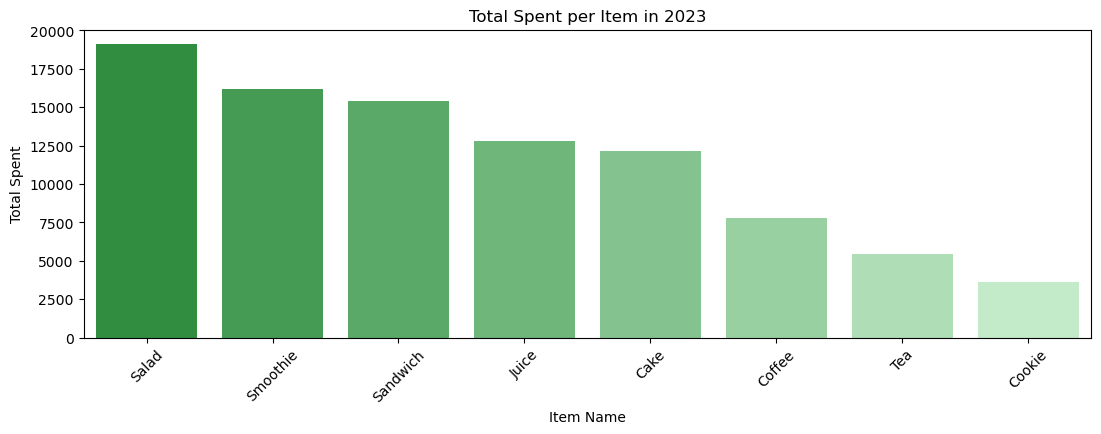

In [178]:
plt.figure(figsize=(13,4))
sns.barplot(data=total_rev_per_item, x='Item', y='Total Spent', palette='blend:#219E37,#BCF1C5')
plt.title("Total Spent per Item in 2023")
plt.xlabel('Item Name')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.show()

In [175]:
Highest_sales_ownby = total_rev_per_item.loc[total_rev_per_item['Total Spent'].idxmax(), 'Item']
Highest_sales_ownby

'Salad'

The highest sales owns by 'Salad' followed by 'Smoothie', and the least sales is 'Cookie' 

### 2. What is the most odered item in 2023? ###

In [176]:
most_ordered_item = df.groupby('Item')['Quantity'].sum().reset_index()
most_ordered_item = most_ordered_item.sort_values(by='Quantity', ascending=False)
most_ordered_item

,Item,Quantity
3,Juice,4262.0
6,Smoothie,4040.0
1,Coffee,3904.0
4,Salad,3819.0
7,Tea,3650.0
2,Cookie,3598.0
0,Cake,3464.0
5,Sandwich,3429.0


/var/folders/lg/fsm8s9v909b1k6v2b54vczfw0000gn/T/ipykernel_3867/1418647061.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=most_ordered_item, x='Item', y='Quantity', palette='blend:#219E37,#BCF1C5')


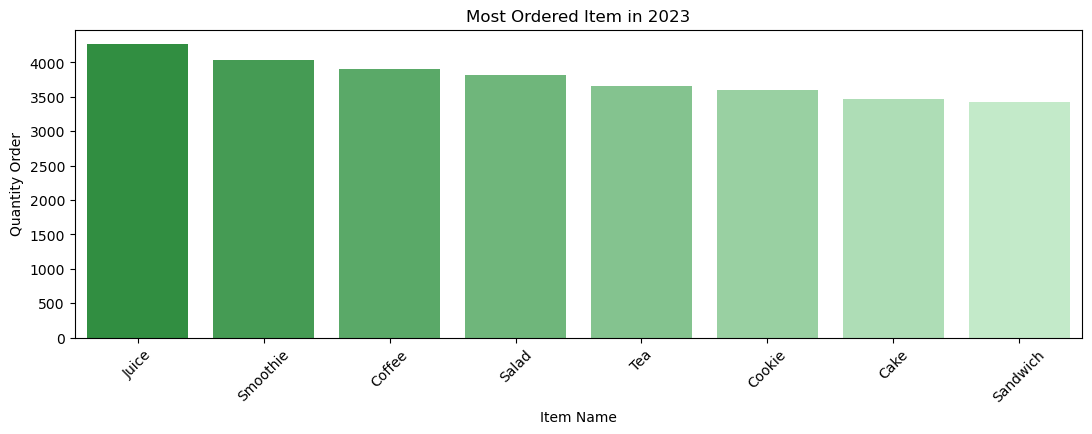

In [180]:
plt.figure(figsize=(13,4))
sns.barplot(data=most_ordered_item, x='Item', y='Quantity', palette='blend:#219E37,#BCF1C5')
plt.title('Most Ordered Item in 2023')
plt.xlabel('Item Name')
plt.ylabel('Quantity Order')
plt.xticks(rotation=45)
plt.show()

Juice was the most ordered item in 2023, followed by Smoothie. The gap in the total quantity ordered between each item is not that significant.

### 3. What is the most used payment method in Cafe during 2023? ###

In [188]:
most_used_paymentmethod = df['Payment Method'].value_counts(normalize=True).reset_index()
most_used_paymentmethod = pd.DataFrame(most_used_paymentmethod)
most_used_paymentmethod

,Payment Method,proportion
0,Others,0.317626
1,Digital Wallet,0.228995
2,Credit Card,0.227391
3,Cash,0.225988


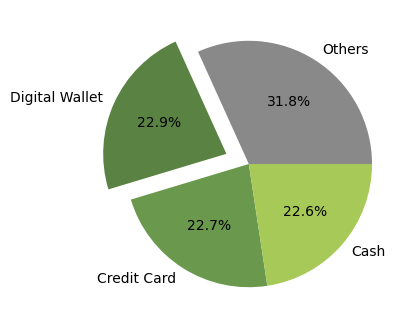

In [210]:
plt.figure(figsize=(8, 4))
# Create an array with the colors 
colors = ["#898989","#5A8243", "#6a994e","#a7c957"]
# Set custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

explode = [0.2 if x == most_used_paymentmethod.loc[most_used_paymentmethod['proportion'].idxmax()+1,'Payment Method'] else 0 for x in most_used_paymentmethod['Payment Method']]
plt.pie(most_used_paymentmethod['proportion'], labels=most_used_paymentmethod['Payment Method'], autopct='%1.1f%%', colors=customPalette, explode=explode)
plt.show()



The 'Others' category in Payment Method is used to cover missing values, unknowns, or errors from the system. Based on this graph, since 'Others' has the highest percentage, it proves that the system is still not stable enough to accurately identify the payment method used in transactions. Therefore, the most valid option to be identified as the most used payment method is <b>'Digital Wallet'</b> instead.

### 4. What was the most popular location for customers to enjoy their orders in 2023? ###

In [209]:
most_popular_location = df['Location'].value_counts(normalize=True).reset_index()
most_popular_location = pd.DataFrame(most_popular_location)
most_popular_location

,Location,proportion
0,Others,0.396230
1,Takeaway,0.302386
2,In-store,0.301384


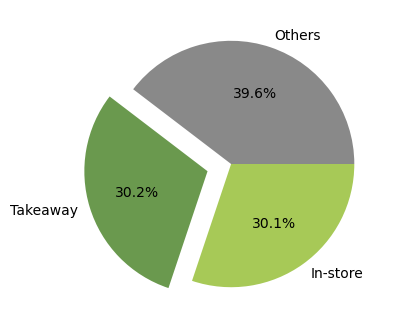

In [212]:
plt.figure(figsize=(8, 4))
# list of colors used
colors = ["#898989", "#6a994e","#a7c957"]
# Set custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

explode = [0.2 if x == most_popular_location.loc[most_popular_location['proportion'].idxmax()+1,'Location'] else 0 for x in most_popular_location['Location']]
plt.pie(most_popular_location['proportion'], labels=most_popular_location['Location'], autopct='%1.1f%%', colors=customPalette, explode=explode)
plt.show()



The 'Others' category under 'Location' is likewise utilized to represent missing data, unidentified entries, or system errors. This situation is quite similar to the case with 'Payment Method.' Therefore, the most reliable option to represent the most popular choice among customers is <b>'Takeaway.'</b>

In [69]:
result = df.groupby(['Transaction Month','Month ID'], as_index=False).agg({'Transaction ID': 'count','Total Spent':'sum'}).sort_values(['Month ID'], ascending=True)
result = result.set_index('Transaction Month')
result.head()


,Month ID,Transaction ID,Total Spent
Transaction Month,,,
January,1,841,7731.5
February,2,770,7110.5
March,3,857,7893.0
April,4,790,7646.5
May,5,818,7602.0


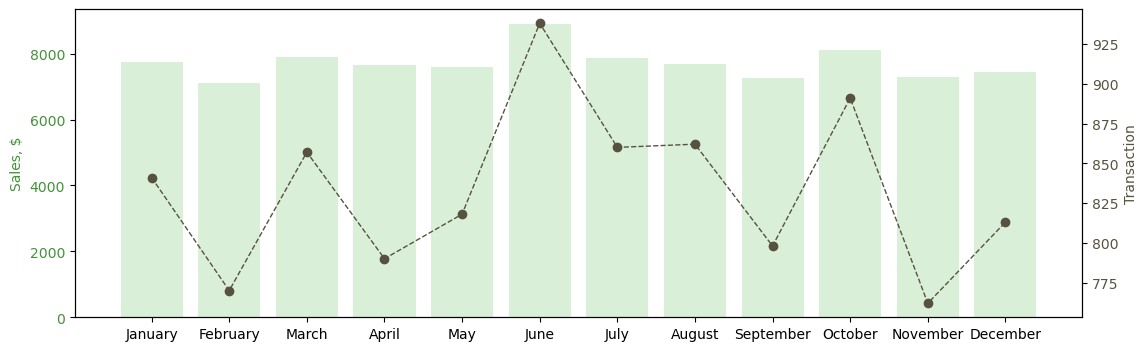

In [70]:
fig, ax1 = plt.subplots(figsize=(13, 4))
ax1.bar(result.index, result['Total Spent'], color = '#A2D99B', alpha=0.4)
ax1.tick_params(axis='y', labelcolor='#429238')
ax1.set_ylabel('Sales, $', color='#429238')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Transaction', color='#575240')
result['Transaction ID'].plot(ax=ax2, color = '#575240', linestyle = '--', lw=1, label='Total Transaction', marker = 'o')
ax2.tick_params(axis='y', labelcolor='#575240')

June is the month where most transaction occured compare the entire years. October was the second place followed by March and July. 

In [123]:
result = df.groupby(['Transaction Month','Month ID','Day of the Week','Day ID'], as_index=False).agg({'Total Spent':'sum'}).sort_values(by=['Month ID', 'Day ID'], ascending=[True, False], ignore_index=True)
result['Ranking'] = result.groupby(['Month ID'])['Total Spent'].rank(ascending=True)
result['Total Spent'] = round(result['Total Spent'],4)
result[result['Month ID'] == 6]


,Transaction Month,Month ID,Day of the Week,Day ID,Total Spent,Ranking
35,June,6,Sunday,6,1185.0,4.0
36,June,6,Saturday,5,1096.0,2.0
37,June,6,Friday,4,1816.5,7.0
38,June,6,Thursday,3,1447.0,6.0
39,June,6,Wednesday,2,1121.5,3.0
40,June,6,Tuesday,1,1207.0,5.0
41,June,6,Monday,0,1028.5,1.0


[Text(158.22222222222223, 0.5, ''), Text(0.5, 14.722222222222216, '')]

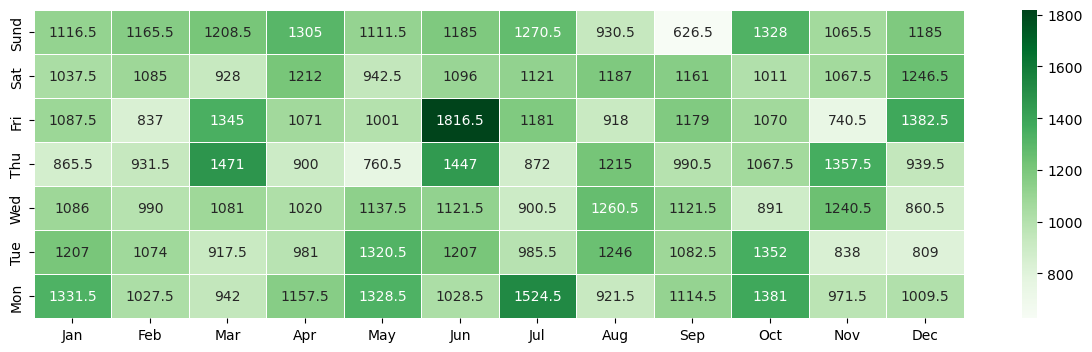

In [124]:
res_pivot=result.pivot_table(index='Day ID', columns='Month ID', values='Total Spent')
fig, ax = plt.subplots(figsize=(15,4)) 
ylabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sund']
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax = sns.heatmap(res_pivot, annot=True, linewidth=.5, fmt='.5g', cmap='Greens', yticklabels=ylabels, xticklabels=xlabels )
ax.invert_yaxis()
ax.set(ylabel='', xlabel='')



[Text(158.22222222222223, 0.5, ''), Text(0.5, 14.722222222222216, '')]

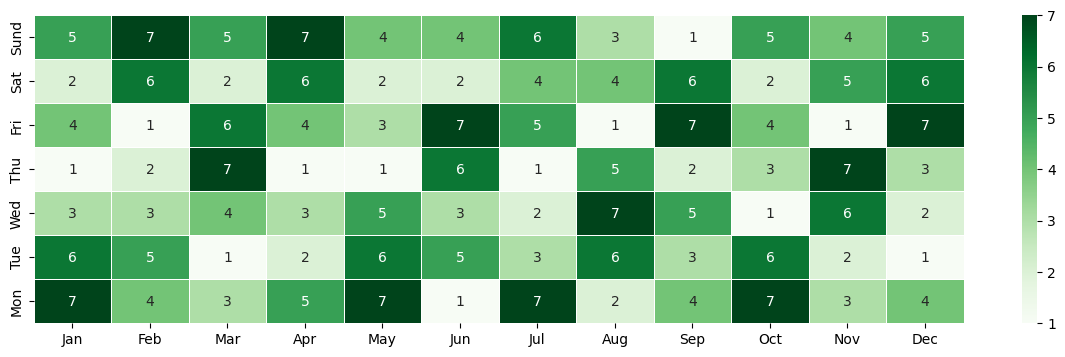

In [125]:
res_pivot=result.pivot_table(index='Day ID', columns='Month ID', values='Ranking')
fig, ax = plt.subplots(figsize=(15,4)) 
ylabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sund']
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax = sns.heatmap(res_pivot, annot=True, linewidth=.5, fmt='.5g', cmap='Greens', yticklabels=ylabels, xticklabels=xlabels )
ax.invert_yaxis()
ax.set(ylabel='', xlabel='')

